Importing the Libraries

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn import metrics

Data Collection and Processing

In [9]:
# loading the csv data to a Pandas DataFrame
gold_data = pd.read_csv('/content/gld_price_data (1).csv')

Temporal Features

In [38]:
# Convert the 'Date' column to datetime format for easier manipulation of date-based features
gold_data['Date'] = pd.to_datetime(gold_data['Date'])

# 1. Date-based Features
gold_data['Year'] = gold_data['Date'].dt.year
gold_data['Month'] = gold_data['Date'].dt.month
gold_data['DayOfWeek'] = gold_data['Date'].dt.dayofweek

# 2. Lagged Features (1-day and 7-day lag for GLD)
gold_data['GLD_Lag1'] = gold_data['GLD'].shift(1)
gold_data['GLD_Lag7'] = gold_data['GLD'].shift(7)

# 3. Rolling Mean and Volatility (7-day and 30-day rolling averages and standard deviations for GLD)
gold_data['GLD_RollingMean_7'] = gold_data['GLD'].rolling(window=7).mean()
gold_data['GLD_RollingMean_30'] = gold_data['GLD'].rolling(window=30).mean()
gold_data['GLD_RollingStd_7'] = gold_data['GLD'].rolling(window=7).std()
gold_data['GLD_RollingStd_30'] = gold_data['GLD'].rolling(window=30).std()



Price Change and Volatility

In [47]:
# 1. Calculate Daily Price Change (%) for GLD
gold_data['GLD_Change'] = gold_data['GLD'].pct_change() * 100  # Percentage change for GLD

# 2. Calculate Rolling Volatility (Standard Deviation of Price Change)
gold_data['GLD_Volatility_7'] = gold_data['GLD_Change'].rolling(window=7).std()  # 7-day volatility
gold_data['GLD_Volatility_30'] = gold_data['GLD_Change'].rolling(window=30).std()  # 30-day volatility

# Repeat the same for other columns if needed (e.g., SPX, SLV)
# Example for SPX:
gold_data['SPX_Change'] = gold_data['SPX'].pct_change() * 100
gold_data['SPX_Volatility_7'] = gold_data['SPX_Change'].rolling(window=7).std()
gold_data['SPX_Volatility_30'] = gold_data['SPX_Change'].rolling(window=30).std()

In [48]:
# Drop rows with NaN values that result from rolling and lag operations
gold_data = gold_data.dropna().reset_index(drop=True)


In [49]:
# Save or preview the updated dataset
gold_data.to_csv('price_change_volatility_data.csv', index=False)  # Saves the new dataset to a CSV file
print(gold_data[['Date', 'GLD', 'GLD_Change', 'GLD_Volatility_7', 'GLD_Volatility_30']].head())  # Displays key columns

        Date        GLD  GLD_Change  GLD_Volatility_7  GLD_Volatility_30
0 2008-03-28  91.879997   -1.690565          2.376222           1.637489
1 2008-04-01  86.860001   -5.463644          2.823659           1.926199
2 2008-04-02  89.269997    2.774575          2.898439           1.992472
3 2008-04-03  89.419998    0.168031          2.897797           1.926504
4 2008-04-07  91.169998    1.957057          2.751454           1.931522


In [46]:
# print first 5 rows in the dataframe
gold_data.head()

,Date,SPX,GLD,USO,SLV,EUR/USD,Year,Month,DayOfWeek,GLD_Lag1,GLD_Lag7,GLD_RollingMean_7,GLD_RollingMean_30,GLD_RollingStd_7,GLD_RollingStd_30
0,2008-02-13,1367.209961,89.440002,74.110001,17.132000,1.455604,2008,2,2,89.330002,89.099998,89.654286,88.582333,1.238425,2.100708
1,2008-02-14,1348.859985,89.709999,75.760002,17.087000,1.464408,2008,2,3,89.440002,87.680000,89.944286,88.744000,0.886828,1.987964
2,2008-02-15,1349.989990,89.150002,75.930000,16.952000,1.467610,2008,2,4,89.709999,88.949997,89.972858,88.863333,0.851992,1.896197
3,2008-02-19,1348.780029,91.580002,78.809998,17.378000,1.472993,2008,2,1,89.150002,89.849998,90.220001,89.078333,1.040481,1.822532
4,2008-02-20,1360.030029,93.239998,79.320000,17.700001,1.472299,2008,2,2,91.580002,91.000000,90.540001,89.360667,1.543307,1.787827


In [40]:
# print last 5 rows of the dataframe
gold_data.tail()

,Date,SPX,GLD,USO,SLV,EUR/USD,Year,Month,DayOfWeek,GLD_Lag1,GLD_Lag7,GLD_RollingMean_7,GLD_RollingMean_30,GLD_RollingStd_7,GLD_RollingStd_30
2285,2018-05-08,2671.919922,124.589996,14.0600,15.5100,1.186789,2018,5,1,124.570000,125.410004,124.337142,126.153334,0.491823,1.367692
2286,2018-05-09,2697.790039,124.330002,14.3700,15.5300,1.184722,2018,5,2,124.589996,124.970001,124.245713,126.154001,0.406687,1.366767
2287,2018-05-10,2723.070068,125.180000,14.4100,15.7400,1.191753,2018,5,3,124.330002,124.589996,124.330000,126.110667,0.531820,1.376647
2288,2018-05-14,2730.129883,124.489998,14.3800,15.5600,1.193118,2018,5,0,125.180000,123.709999,124.441428,126.061000,0.456669,1.408044
2289,2018-05-16,2725.780029,122.543800,14.4058,15.4542,1.182033,2018,5,2,124.489998,123.650002,124.283399,125.892127,0.821696,1.515561


In [41]:
# number of rows and columns
gold_data.shape

(2290, 15)

In [42]:
# getting some basic informations about the data
gold_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2290 entries, 0 to 2289
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   Date                2290 non-null   datetime64[ns]
 1   SPX                 2290 non-null   float64       
 2   GLD                 2290 non-null   float64       
 3   USO                 2290 non-null   float64       
 4   SLV                 2290 non-null   float64       
 5   EUR/USD             2290 non-null   float64       
 6   Year                2290 non-null   int32         
 7   Month               2290 non-null   int32         
 8   DayOfWeek           2290 non-null   int32         
 9   GLD_Lag1            2289 non-null   float64       
 10  GLD_Lag7            2283 non-null   float64       
 11  GLD_RollingMean_7   2284 non-null   float64       
 12  GLD_RollingMean_30  2261 non-null   float64       
 13  GLD_RollingStd_7    2284 non-null   float64     

In [43]:
# checking the number of missing values
gold_data.isnull().sum()

,0
Date,0
SPX,0
GLD,0
USO,0
SLV,0
EUR/USD,0
Year,0
Month,0
DayOfWeek,0
GLD_Lag1,1


In [44]:
# getting the statistical measures of the data
gold_data.describe()

,Date,SPX,GLD,USO,SLV,EUR/USD,Year,Month,DayOfWeek,GLD_Lag1,GLD_Lag7,GLD_RollingMean_7,GLD_RollingMean_30,GLD_RollingStd_7,GLD_RollingStd_30
count,2290,2290.000000,2290.000000,2290.000000,2290.000000,2290.000000,2290.000000,2290.000000,2290.000000,2289.000000,2283.000000,2284.000000,2261.000000,2284.000000,2261.000000
mean,2013-03-17 08:23:41.135371008,1654.315776,122.732875,31.842221,20.084997,1.283653,2012.724891,6.329258,1.767686,122.732958,122.728121,122.780264,122.941637,1.458203,2.921220
min,2008-01-02 00:00:00,676.530029,70.000000,7.960000,8.850000,1.039047,2008.000000,1.000000,0.000000,70.000000,70.000000,72.131431,74.267667,0.242408,0.620663
25%,2010-08-20 00:00:00,1239.874969,109.725000,14.380000,15.570000,1.171313,2010.000000,3.000000,1.000000,109.720001,109.709999,109.484999,109.724666,0.893310,1.863295
50%,2013-03-13 12:00:00,1551.434998,120.580002,33.869999,17.268500,1.303297,2013.000000,6.000000,2.000000,120.580002,120.559998,120.487858,119.908000,1.227294,2.541789
75%,2015-10-25 00:00:00,2073.010070,132.840004,37.827501,22.882500,1.369971,2015.000000,10.000000,3.000000,132.850006,132.875000,133.086072,132.962000,1.753542,3.490333
max,2018-05-16 00:00:00,2872.870117,184.589996,117.480003,47.259998,1.598798,2018.000000,12.000000,4.000000,184.589996,184.589996,179.021428,173.925333,10.467907,10.290857
std,NaN,519.111540,23.283346,19.523517,7.092566,0.131547,2.993271,3.591149,1.277286,23.288433,23.318832,23.218585,23.030714,0.946706,1.573726


Correlation:
1. Positive Correlation
2. Negative Correlation

In [36]:

# Calculate the correlation matrix
correlation = gold_data.corr()

<Axes: >

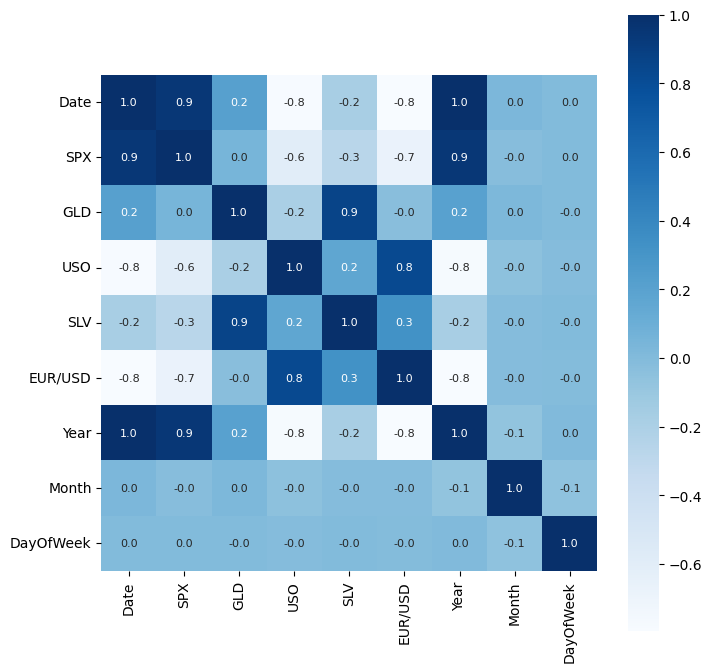

In [51]:
# constructing a heatmap to understand the correlatiom
plt.figure(figsize = (8,8))
sns.heatmap(correlation, cbar=True, square=True, fmt='.1f',annot=True, annot_kws={'size':8}, cmap='Blues')

In [52]:
# correlation values of GLD
print(correlation['GLD'])

Date         0.209118
SPX          0.049345
GLD          1.000000
USO         -0.186360
SLV          0.866632
EUR/USD     -0.024375
Year         0.206654
Month        0.020494
DayOfWeek   -0.001227
Name: GLD, dtype: float64


<ipython-input-53-b94eac2e88dd>:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(gold_data['GLD'],color='green')


<Axes: xlabel='GLD', ylabel='Density'>

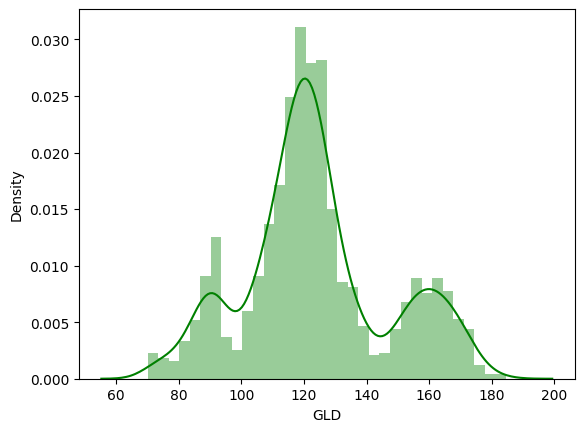

In [53]:
# checking the distribution of the GLD Price
sns.distplot(gold_data['GLD'],color='green')

Splitting the Features and Target

In [54]:
X = gold_data.drop(['Date','GLD'],axis=1)
Y = gold_data['GLD']

In [55]:
print(X)

              SPX        USO        SLV   EUR/USD  Year  Month  DayOfWeek  \
0     1315.219971  84.370003  17.750000  1.576094  2008      3          4   
1     1370.180054  81.059998  16.600000  1.567791  2008      4          1   
2     1367.530029  83.779999  17.246000  1.566711  2008      4          2   
3     1369.310059  83.650002  17.230000  1.573688  2008      4          3   
4     1372.540039  86.930000  17.950001  1.557802  2008      4          0   
...           ...        ...        ...       ...   ...    ...        ...   
2226  2671.919922  14.060000  15.510000  1.186789  2018      5          1   
2227  2697.790039  14.370000  15.530000  1.184722  2018      5          2   
2228  2723.070068  14.410000  15.740000  1.191753  2018      5          3   
2229  2730.129883  14.380000  15.560000  1.193118  2018      5          0   
2230  2725.780029  14.405800  15.454200  1.182033  2018      5          2   

        GLD_Lag1    GLD_Lag7  GLD_RollingMean_7  GLD_RollingMean_30  \
0   

In [56]:
print(Y)

0        91.879997
1        86.860001
2        89.269997
3        89.419998
4        91.169998
           ...    
2226    124.589996
2227    124.330002
2228    125.180000
2229    124.489998
2230    122.543800
Name: GLD, Length: 2231, dtype: float64


Splitting into Training data and Test Data

In [57]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state=2)

Build the Linear Regression Model

In [58]:
# Create and train the model
model = LinearRegression()
model.fit(X_train, y_train)

# Predict the test set results
y_pred = model.predict(X_test)


Model Training: Linear Regressor


In [59]:
# Calculate metrics
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f'MSE: {mse}')
print(f'RMSE: {rmse}')
print(f'R-squared: {r2}')


MSE: 0.23761515931515498
RMSE: 0.4874578538860103
R-squared: 0.9995532601627781


Model Training:Random Forest Regressor

In [60]:
regressor = RandomForestRegressor(n_estimators=100)

Model Evaluation

In [61]:
# training the model
regressor.fit(X_train,y_train)

RandomForestRegressor()

In [62]:
# prediction on Test Data
test_data_prediction = regressor.predict(X_test)

In [63]:
print(test_data_prediction)

[ 95.02810014 117.48499973 113.44950151 130.46410057 125.6751004
 152.72800005  72.41740105 118.51870046 122.18649894 155.54119795
 138.50129911  92.35879919 157.55440134 128.3816991  125.83039976
 151.92500069 118.99090115 156.12700211 114.38310067 121.93420044
 112.22420084 128.89740043 167.69779913 128.47639873 156.12290162
 118.58030018 126.33290007  93.14059905 157.36270022 122.05720009
 130.99450063  86.56269934 124.93370054 122.53509909 130.72460065
 164.54400093 115.10070077 156.68620159 139.43289928 120.15490108
 122.86772835 108.40530011 118.65599838  91.21600038 115.99560094
 133.57760166 126.5048998  105.73480148 105.88019991 129.5081989
 122.63657524  87.47789965 119.98790097 120.79950025  79.0372995
 129.41369953 114.18280022  78.10499969 116.48840023 126.89050031
 162.03349967  85.58849868 179.55119788  80.82589956 124.73950002
 126.46119985 163.70819772 132.44310041 126.1873001  125.7570007
 160.03280018 152.20459942 127.14409902 131.73200205 105.48649967
 156.6730019  

In [30]:
# R squared error
error_score = metrics.r2_score(y_test, test_data_prediction)
print("R squared error : ", error_score)

R squared error :  0.9893264204865747


Compare the Actual Values and Predicted Values in a Plot

In [64]:
y_test = list(y_test)

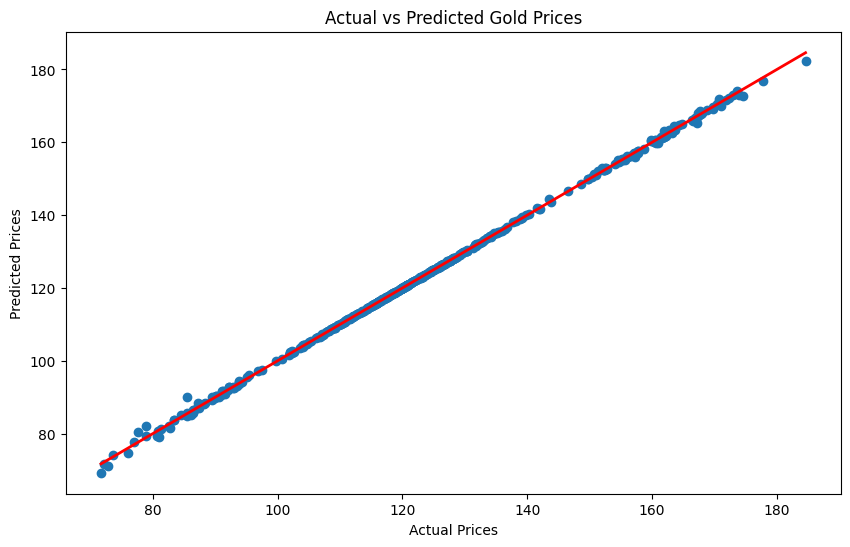

In [65]:
plt.figure(figsize=(10,6))
plt.scatter(y_test, y_pred)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', lw=2)
plt.xlabel('Actual Prices')
plt.ylabel('Predicted Prices')
plt.title('Actual vs Predicted Gold Prices')
plt.show()
